In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import json

Our metric of an actor's success can be based on two factors: 
 - awards (we consider 3 prestigiuos awards: Oscar, Golden Globe and Critics Choice) show an actor's recognition by the professional community
 - popularity shows an actor's recognition by the broad audience

We can aggregate these factors as follows:

$ Success(P, N, W, t) = P\_scale(t) * P + N\_scale * N + W\_scale * W $

In the formula P corresponds to popularity (from TMDB or new database with the most popular actors), W is the number of times the actor became an award winner or, in case of Oscar, nominant. Scaling factors are constants for an award-related part, but $P\_scale(t)$ is a decreasing function of time period - how far was a peak of an actor's career from now. The motivation is that the popularity of actors who starred recently is supposed to be higher than the popularity of their retired colleagues.

In [3]:
# database with Oscar awards retrieved from https://en.wikipedia.org/wiki/List_of_actors_with_Academy_Award_nominations
oscars_df = pd.read_csv('../Data/preprocessed_data/oscars_db.csv')
# database with Golden Globe awards
gg_awards_df = pd.read_csv('../Data/preprocessed_data/gg_awards.csv')
# database with Critic Choise awards
cc_awards_df = pd.read_csv('../Data/preprocessed_data/cc_awards.csv')

In [4]:
gg_awards_df = gg_awards_df.rename(columns={"Actor": "name"})
cc_awards_df = cc_awards_df.rename(columns={"Actor": "name"})

In [5]:
# give more weight to the Oscar wins compared to nominations
oscars_df["wins"] = oscars_df["wins"].apply(lambda x: 2*x)
# some competitive categories of an award are considered more important, so we give them more weight
for col_name in ["GG_Best_Actor_Drama", "GG_Best_Actress_Drama",
                 "GG_Best_Actor_Comedy_or_Musical", "GG_Best_Actress_Comedy_or_Musical"]:
    gg_awards_df[col_name] = gg_awards_df[col_name].apply(lambda x: 2*x)
for col_name in ["Best_Actor", "Best_Actress"]:
    cc_awards_df[col_name] = cc_awards_df[col_name].apply(lambda x: 2*x)

In [6]:
oscars_df["oscar_total"] = oscars_df[["nominations", "wins"]].sum(axis=1)
oscars_df = oscars_df[["name", "oscar_total"]]
gg_awards_df["gg_total"] = gg_awards_df[["GG_Best_Actor_Drama", "GG_Best_Actress_Drama", 
                                         "GG_Best_Supporting_Actor", "GG_Best_Supporting_Actress", 
                                         "GG_Best_Actor_Comedy_or_Musical",
                                         "GG_Best_Actress_Comedy_or_Musical"]].sum(axis=1)
gg_awards_df = gg_awards_df[["name", "gg_total"]]
cc_awards_df["cc_total"] = cc_awards_df[["Best_Actor", "Best_Actress", "Best_Supporting_Actor",
                                         "Best_Supporting_Actress"]].sum(axis=1)
cc_awards_df = cc_awards_df[["name", "cc_total"]]

In [7]:
gg_awards_sum_df = gg_awards_df.groupby(by="name").sum()
cc_awards_sum_df = cc_awards_df.groupby(by="name").sum()

In [9]:
filtered_actors = pd.read_csv("../Data/preprocessed_data/acting_in_2003_and_later.csv")

In [8]:
awards_df = pd.merge(left=oscars_df, right=gg_awards_sum_df, how='outer', on="name")
awards_df = pd.merge(left=awards_df, right=cc_awards_sum_df, how='outer', on="name")
awards_df = awards_df.fillna(0.0)
awards_df['awards_total'] = awards_df[['oscar_total', 'gg_total', 'cc_total']].sum(axis=1)
# awards_df = awards_df[["name", "awards_total"]]
display(awards_df)

,name,oscar_total,gg_total,cc_total,awards_total
0,Barkhad Abdi,1.0,1.0,1.0,3.0
1,F. Murray Abraham,3.0,2.0,0.0,5.0
2,Amy Adams,6.0,12.0,7.0,25.0
3,Nick Adams,1.0,0.0,0.0,1.0
4,Isabelle Adjani,2.0,0.0,0.0,2.0
...,...,...,...,...,...
1352,Sidney Flanigan,0.0,0.0,2.0,2.0
1353,Sterling K. Brown,0.0,0.0,1.0,1.0
1354,Tiffany Haddish,0.0,0.0,1.0,1.0
1355,Zendaya,0.0,0.0,2.0,2.0


In [10]:
filtered_actors_with_awards = pd.merge(left=filtered_actors["name"], right=awards_df, 
                                       how="outer", on="name")

In [12]:
filtered_actors_with_awards = filtered_actors_with_awards.fillna(0.0)
display(filtered_actors_with_awards)

,name,oscar_total,gg_total,cc_total,awards_total
0,Gary Oldman,5.0,4.0,4.0,13.0
1,Jason Statham,0.0,0.0,0.0,0.0
2,Jackie Chan,0.0,0.0,0.0,0.0
3,Scarlett Johansson,2.0,9.0,5.0,16.0
4,Josh Hutcherson,0.0,0.0,0.0,0.0
...,...,...,...,...,...
6580,Michelle Williams (TIE),0.0,0.0,1.0,1.0
6581,Sandra Bullock (TIE),0.0,0.0,2.0,2.0
6582,Sidney Flanigan,0.0,0.0,2.0,2.0
6583,Zendaya,0.0,0.0,2.0,2.0


In [15]:
filtered_actors_with_awards.to_csv("filtered_actors_with_awards.csv", index=False)

In [9]:
plt.figure(figsize=(10, 6))

plt.hist(awards_df['oscar_total'], bins=30, alpha=0.3, label='Oscar')
plt.hist(awards_df['cc_total'], bins=30, alpha=0.3, label='Critic Choice')
plt.hist(awards_df['gg_total'], bins=30, alpha=0.3, label='Golden Globe')

plt.xlabel('Number of awards')
plt.ylabel('Number of actors')
plt.legend()

: 

In [2]:
plt.plot(np.arange(3), np.arange(3))

: 

Popularity of the actors and films they are known for were extracted in Preprocessing/actors_preprocessing.ipynb. In our analysis we are targeting Hollywood actors, since the Oscar is Hollywood-biased. For this, we apply filtering based on the prevalent language of the most popular films ("original_language" field in the database) of each actor and leave only English ones. 

*This filtering does not reject British film industry but their movies and actors are also eligible for Oscar.

In [175]:
actors_df = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
actors_df = actors_df[actors_df["original_language"] == "en"] # English movies filtering
popularity_df = actors_df[["name", "popularity", "known_for"]] # for each actor known_for contains top-3 most recognised movies
display(popularity_df)
print(f"There are {popularity_df.shape[0]} actors in the filtered dataset")

,name,popularity,known_for
1,Gary Oldman,220.449,"[{'adult': False, 'backdrop_path': '/nMKdUUepR..."
3,Florence Pugh,176.589,"[{'adult': False, 'backdrop_path': '/aAM3cQmYG..."
4,Jason Statham,162.466,"[{'adult': False, 'backdrop_path': '/ysKahAEPP..."
6,Jackie Chan,156.714,"[{'adult': False, 'backdrop_path': '/r4yFYBEcV..."
7,Scarlett Johansson,156.460,"[{'adult': False, 'backdrop_path': '/ozVwXlfxq..."
...,...,...,...
9574,Richard Derr,14.134,"[{'adult': False, 'backdrop_path': '/ws8eX1paK..."
9575,Michael Maloney,14.134,"[{'adult': False, 'backdrop_path': '/9YoLdWeBS..."
9576,Gaia Scodellaro,14.133,"[{'adult': False, 'backdrop_path': '/tC78Pck2Y..."
9578,Peter Cullen,14.133,"[{'adult': False, 'backdrop_path': '/2vFuG6bWG..."


There are 8441 actors in the filtered dataset


We need to extract additionally the date of release of the newest popular movie to make time scaling

In [176]:
def get_last_release_date(movie_column):
    actor_movies = movie_column.values
    last_release_dates = []
    for movie_str in actor_movies:
        movie_list = ast.literal_eval(movie_str)
        last_release_dates.append(sorted([x["release_date"] if "release_date" in x else "None" for x in movie_list])[-1])
    print(len(last_release_dates))
    return last_release_dates

popularity_df = popularity_df.assign(last_release_date = get_last_release_date(popularity_df["known_for"]))
popularity_df = popularity_df[popularity_df["last_release_date"] != "None"]
popularity_df["last_release_date"] = pd.to_datetime(popularity_df["last_release_date"], yearfirst=True)
popularity_df.head()

8441


,name,popularity,known_for,last_release_date
1,Gary Oldman,220.449,"[{'adult': False, 'backdrop_path': '/nMKdUUepR...",2017-11-22
3,Florence Pugh,176.589,"[{'adult': False, 'backdrop_path': '/aAM3cQmYG...",2021-07-07
4,Jason Statham,162.466,"[{'adult': False, 'backdrop_path': '/ysKahAEPP...",2018-08-09
6,Jackie Chan,156.714,"[{'adult': False, 'backdrop_path': '/r4yFYBEcV...",2007-08-08
7,Scarlett Johansson,156.460,"[{'adult': False, 'backdrop_path': '/ozVwXlfxq...",2021-07-07


Text(0.5, 1.0, 'Evolution of median popularity of actors depending on date of their last movie release')

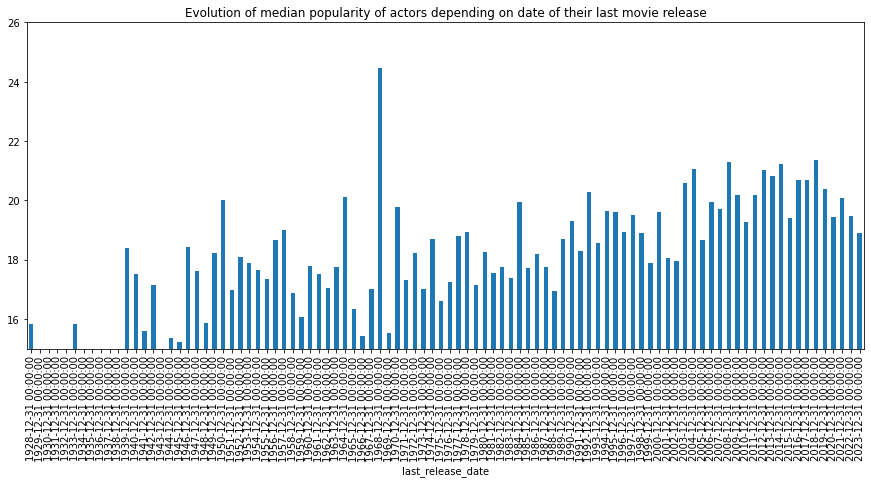

In [158]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylim(15, 26)
popularity_df['popularity'].resample('A').median().plot(kind='bar')
plt.title("Evolution of median popularity of actors depending on date of their last movie release")

Text(0.5, 1.0, 'Evolution of mean popularity of actors depending on date of their last movie release')

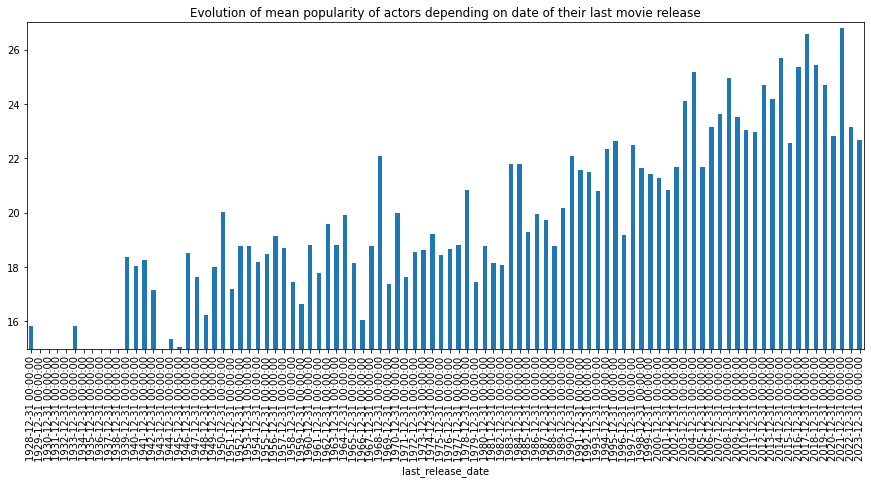

In [159]:
fig, ax = plt.subplots(figsize=(15,6))
popularity_df['popularity'].resample('A').mean().plot(kind='bar')
ax.set_ylim(15, 27)
plt.title("Evolution of mean popularity of actors depending on date of their last movie release")

Median actor popularity doesn't change much over time, but mean popularity is slightly higher for actors who was starring in popular movies recently. It indicates the presence of "outlier" actors who have extremely high popularity and play in recent movies. To address this issue, we can slightly penaltize the popularity for actors whose career peaks were less that 20 years from now (the period of mean popularity rise on the graph)

In [177]:
def date_to_year(date):
    return int(date.strftime('%Y-%m-%d').split("-")[0])

def time_scaling(release_dates, coef=.1):
    t_max = 2003
    release_dates = release_dates.apply(lambda x: np.exp(-(date_to_year(x) - t_max) / (coef * t_max))) \
                                        #if date_to_year(x) > t_max else 1.0)
    return release_dates

popularity_df = popularity_df.assign(popularity_scaled = popularity_df["popularity"] * \
                                     time_scaling(popularity_df["last_release_date"]))
# popularity_df = popularity_df.set_index("last_release_date")
popularity_df.head()

,name,popularity,known_for,last_release_date,popularity_scaled
1,Gary Oldman,220.449,"[{'adult': False, 'backdrop_path': '/nMKdUUepR...",2017-11-22,205.566836
3,Florence Pugh,176.589,"[{'adult': False, 'backdrop_path': '/aAM3cQmYG...",2021-07-07,161.411951
4,Jason Statham,162.466,"[{'adult': False, 'backdrop_path': '/ysKahAEPP...",2018-08-09,150.743706
6,Jackie Chan,156.714,"[{'adult': False, 'backdrop_path': '/r4yFYBEcV...",2007-08-08,153.615456
7,Scarlett Johansson,156.460,"[{'adult': False, 'backdrop_path': '/ozVwXlfxq...",2021-07-07,143.012950


Text(0.5, 1.0, 'Evolution of scaled mean popularity of actors depending on date of their last movie release')

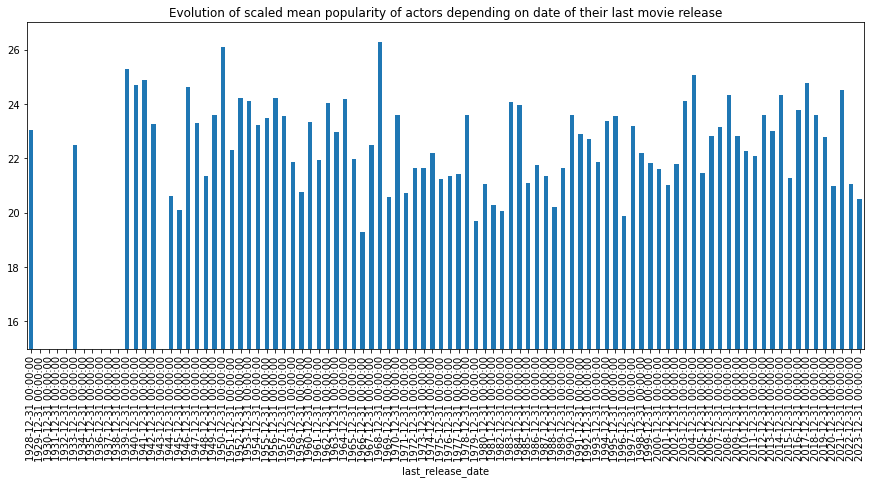

In [168]:
fig, ax = plt.subplots(figsize=(15,6))
popularity_df['popularity_scaled'].resample('A').mean().plot(kind='bar')
ax.set_ylim(15, 27)
plt.title("Evolution of scaled mean popularity of actors depending on date of their last movie release")

In [182]:
# drop the columns we don't need for the metric
popularity_df = popularity_df[["name", "popularity_scaled"]]

In [183]:
# merging 2 databases to get popularity, nominations and awards in a single database
success_df = pd.merge(left=popularity_df, right=oscars_df, how="left", on=["name"])
success_df = success_df.fillna(0)
display(success_df)

,name,popularity_scaled,nominations,wins
0,Gary Oldman,205.566836,3.0,1.0
1,Florence Pugh,161.411951,1.0,0.0
2,Jason Statham,150.743706,0.0,0.0
3,Jackie Chan,153.615456,0.0,0.0
4,Scarlett Johansson,143.012950,2.0,0.0
...,...,...,...,...
5652,Lyle Lovett,14.205746,0.0,0.0
5653,Richard Derr,15.696315,0.0,0.0
5654,Michael Maloney,12.919245,0.0,0.0
5655,Peter Cullen,12.789983,0.0,0.0


In [184]:
P_SCALE = 1.0 # move time-dependence to popularity
N_SCALE = 5.0
W_SCALE = 10.0

success_df = success_df.assign(metric = lambda x: P_SCALE * success_df["popularity_scaled"] + \
                               N_SCALE * success_df["nominations"] + W_SCALE * success_df["wins"])
success_df.head()

,name,popularity_scaled,nominations,wins,metric
0,Gary Oldman,205.566836,3.0,1.0,230.566836
1,Florence Pugh,161.411951,1.0,0.0,166.411951
2,Jason Statham,150.743706,0.0,0.0,150.743706
3,Jackie Chan,153.615456,0.0,0.0,153.615456
4,Scarlett Johansson,143.012950,2.0,0.0,153.012950


According to our metric, here are the top actors

In [186]:
success_df = success_df.sort_values(by="metric", ascending=False)
success_df.head(10)

,name,popularity_scaled,nominations,wins,metric
0,Gary Oldman,205.566836,3.0,1.0,230.566836
1,Florence Pugh,161.411951,1.0,0.0,166.411951
1290,Meryl Streep,24.906850,21.0,3.0,159.906850
7,Nicolas Cage,135.065668,2.0,1.0,155.065668
3,Jackie Chan,153.615456,0.0,0.0,153.615456
4,Scarlett Johansson,143.012950,2.0,0.0,153.012950
2,Jason Statham,150.743706,0.0,0.0,150.743706
6,Brie Larson,134.852069,1.0,1.0,149.852069
9,Kevin Costner,139.291687,1.0,0.0,144.291687
5,Josh Hutcherson,140.788012,0.0,0.0,140.788012
